# Track videos with your trained network

Once you have a well-trained network, you can use it to extract the position of the different objects in a video.


## GPU access

You will need to get a Runtime with GPU access. Click on Runtime/Change runtime type. Select GPU as hardware accelerator.

In [1]:
!pip install albumentations==1.3.0
!git clone https://github.com/kevin-allen/unetTracker
!pip install -r unetTracker/requirements.txt
!pip install -e unetTracker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1
Cloning into 'unetTracker'...
remote: Enumerating objects: 825, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 825 (delta 110), reused 100 (delta 41), pack-reused 621
Receiving objects: 100% (825/825), 122.30 MiB | 24.08 MiB/s, done.
Resolving deltas: 100% (500/500), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.0/379.0 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 8.6 

Obtaining file:///content/unetTracker
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for unetTracker (pyproject.toml) ... done
  Created wheel for unetTracker: filename=unetTracker-0.0.1-0.editable-py3-none-any.whl size=15897 sha256=b514daab713229b7b00a056d64bf180adeb1ce1f1004787ff8675386bd1025b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-0bw0t_l3/wheels/62/9b/5a/0cb547490a9187d698861d98e1e803c5e64f31a9d899a8e84c
Successfully built unetTracker


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
fn = "/content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/finger_tracker/config.yalm"
if os.path.exists(fn):
  print("We can access the unet-tracker project directory.")
else:
  raise IOError("Problem accessing the unet-tracker project directory.")

We can access the unet-tracker project directory.


In [3]:
import torch
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet
from unetTracker.utils import extract_object_position_from_video

In [4]:
project = TrackingProject(name="finger_tracker",
                          root_folder = "/content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/")

Project directory: /content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/finger_tracker
Getting configuration from config file. Values from config file will be used.
Loading /content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/finger_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'finger_tracker', 'normalization_values': {'means': [0.40835028886795044, 0.4549056589603424, 0.51627117395401], 'stds': [0.23996737599372864, 0.251758873462677, 0.26929107308387756]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (240.0, 255.0, 255.0)], 'objects': ['f1', 'f2', 'f3', 'f4'], 'target_radius': 6, 'unet_features': [64, 128, 256, 512

In [5]:
dataset = UNetDataset(image_dir=project.image_dir, mask_dir=project.mask_dir, coordinate_dir=project.coordinate_dir)

In [6]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print("Training on device {}".format(device))

Training on device cuda


In [7]:
model = Unet(in_channels=3,out_channels=len(project.object_list)).to(device)
project.load_model(model)
_ = model.eval()

In [8]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))

Loading valTransform from /content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/finger_tracker/augmentation/valTransform


In [9]:
valTransform

Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.40835028886795044, 0.4549056589603424, 0.51627117395401], std=[0.23996737599372864, 0.251758873462677, 0.26929107308387756], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

The transformation should only include the normalization. No translation, flip or cropping.

In [10]:
video_fn = '/content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/finger_tracker/videos/human_hand.mp4'
if os.path.exists(video_fn):
  print("We can access the video file.")
else:
  raise IOError("Problem accessing {}".format(video_fn))

We can access the video file.


In [11]:
df = extract_object_position_from_video(project=project,transform=valTransform,
                                        model=model,device=device,
                                        video_fn=video_fn,blobMinArea=10,
                                        plotData=False,
                                        #nFrames=10000,
                                        #startFrameIndex=15*60*3,
                                        BGR2RGBTransformation=False)

Number of frames in /content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/finger_tracker/videos/human_hand.mp4: 5795
Processing 5795 frames from index 0


  0%|          | 0/5795 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 5795/5795 [05:31<00:00, 17.48it/s]


In [12]:
newFileName = (os.path.splitext(video_fn)[0]) + ".csv"
print("Saving ",newFileName)
df.to_csv(newFileName,index=False)

Saving  /content/drive/My Drive/teaching_thesis_taq/Data_science_neuroscience/master_neuroscience_2023/unetTracker/finger_tracker/videos/human_hand.csv


In [13]:
df = pd.read_csv(newFileName)
df

,f1_x,f1_y,f1_p,f2_x,f2_y,f2_p,f3_x,f3_y,f3_p,f4_x,f4_y,f4_p
0,NaN,NaN,0.007293,NaN,NaN,0.007133,NaN,NaN,0.050821,NaN,NaN,0.014694
1,NaN,NaN,0.007296,NaN,NaN,0.007152,NaN,NaN,0.050932,NaN,NaN,0.014611
2,NaN,NaN,0.007289,NaN,NaN,0.007114,NaN,NaN,0.050596,NaN,NaN,0.014721
3,NaN,NaN,0.005828,NaN,NaN,0.046638,206.159378,43.680931,0.645877,NaN,NaN,0.028295
4,NaN,NaN,0.005828,NaN,NaN,0.046616,206.158127,43.678642,0.645920,NaN,NaN,0.028260
...,...,...,...,...,...,...,...,...,...,...,...,...
5790,330.373901,132.920807,0.982072,287.991699,119.906235,0.977129,259.242798,119.759071,0.951335,228.095657,131.402878,0.977867
5791,330.444855,133.077637,0.980356,288.312531,120.117531,0.976894,259.438690,119.921822,0.944475,228.392242,131.664368,0.975397
5792,330.444855,133.077637,0.980350,288.292969,120.084785,0.976817,259.448669,119.913094,0.944632,228.397644,131.658295,0.975452
5793,330.444855,133.077637,0.980353,288.290466,120.112312,0.976955,259.446594,119.969437,0.947463,228.403748,131.667114,0.975603


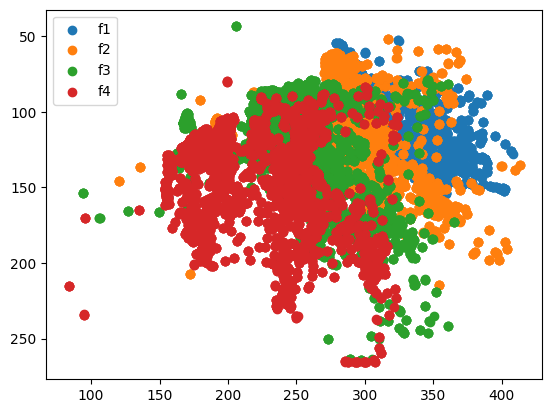

In [14]:
for obj in project.object_list:
    plt.scatter(df[f"{obj}_x"],df[f"{obj}_y"],label=obj)
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.legend()


In [15]:
obj = project.object_list[0]
cName = f"{obj}_x"
print("Number of Nan:", np.sum(np.isnan(df[cName])))
print("percentage of Nan: {:.2f}%".format(np.sum(np.isnan(df[cName]))/len(df[cName])*100))

Number of Nan: 364
percentage of Nan: 6.28%


You can move the tracked data back to you local computer.

SyntaxError: ignored